In [288]:
%matplotlib inline
import nibabel as nb
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
#import nipy.algorithms.registration
from t1_fitter_purepy import T1_fitter

In [289]:
gs_ni = nb.load('/predator-scratch/muxt1/8194_IR_EPI.nii.gz')
si_ni = nb.load('/home/huawu/tmp/t1/mux3r2_fatsat_OFF_pe0_sorted.nii.gz')
gs_raw = gs_ni.get_data().astype(np.float)
si_raw = si_ni.get_data().astype(np.float)

fwhm = 0.0
if fwhm>0:
    import scipy.ndimage as ndimage
    sd = fwhm/np.array(gs_ni._header.get_zooms()[0:3])/2.355
    print('Smoothing GS with %0.1f mm FWHM Gaussian (sigma=[%0.2f,%0.2f,%0.2f] voxels)...' % (tuple([fwhm]+sd.tolist())))
    for i in xrange(gs_raw.shape[3]):
        ndimage.gaussian_filter(gs_raw[...,i], sigma=sd, output=gs_raw[...,i])
    sd = fwhm/np.array(si_ni._header.get_zooms()[0:3])/2.355
    print('Smoothing SI with %0.1f mm FWHM Gaussian (sigma=[%0.2f,%0.2f,%0.2f] voxels)...' % (tuple([fwhm]+sd.tolist())))
    for i in xrange(si_raw.shape[3]):
        ndimage.gaussian_filter(si_raw[...,i], sigma=sd, output=si_raw[...,i])

In [5]:
gs_ni.shape

(127, 127, 28)

In [290]:
coords = [[-33.,0.,28.],[-33.,2.,28.],[-33.,4.,28.],[-33.,6.,28.],[-33.,8.,28.]]

gs_vox = nb.affines.apply_affine(np.linalg.inv(gs_ni.get_affine()),coords).round().astype(int)
si_vox = nb.affines.apply_affine(np.linalg.inv(si_ni.get_affine()),coords).round().astype(int)

gs_ti = np.array([50.,400.,1200.,2400.])
#si_ti = np.array([50.0, 280.77, 511.54, 742.31, 973.08, 1203.85, 1434.62, 1665.38, 1896.15, 2126.92, 2357.69, 2588.46, 2819.23])
tr = 3000.
nti = 23
ti1 = 50.
ti_delta = tr/nti
si_ti = np.arange(nti-1)*ti_delta + ti1

In [291]:
gs_roi

array([[ 1.30741829,  0.30998063,  0.879945  ,  1.53240422],
       [ 1.29241922,  0.29748141,  0.85744641,  1.55490282],
       [ 1.26617086,  0.28623211,  0.879945  ,  1.53240422],
       [ 1.2911693 ,  0.32622961,  0.88494469,  1.5311543 ],
       [ 1.26367102,  0.29248172,  0.88994438,  1.52365477]])

In [292]:
gs_roi = gs_raw[gs_vox[:,0],gs_vox[:,1],gs_vox[:,2],:]
si_roi = si_raw[si_vox[:,0],si_vox[:,1],si_vox[:,2],:]

gs_roi = gs_roi/gs_roi.mean()
si_roi = si_roi/si_roi.mean()

(910.0, 910.0)
(949.0, 931.0)
(920.0, 805.0)
(928.0, 862.0)
(911.0, 870.0)


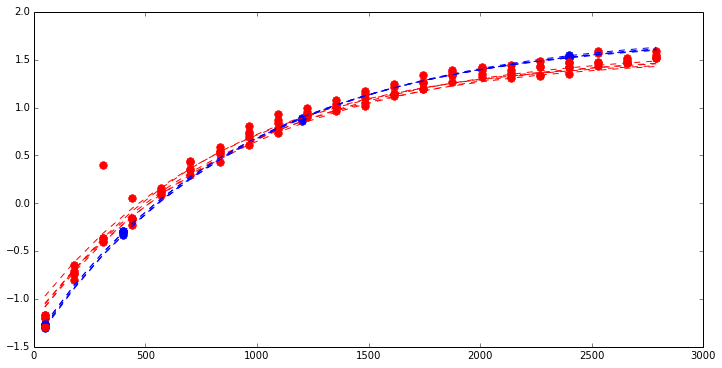

In [309]:
gs_fit = T1_fitter(gs_ti)
si_fit = T1_fitter(si_ti)

plt.figure(figsize=(12,6))
for i in xrange(gs_roi.shape[0]):
    gs_t1,gs_b,gs_a,gs_res,gs_ind = gs_fit.t1_fit_nlspr(gs_roi[i,:])
    si_t1,si_b,si_a,si_res,si_ind = si_fit.t1_fit_nlspr(si_roi[i,:]-.06)

    gs_model = gs_a + gs_b*np.exp(-si_ti / gs_t1)
    si_model = si_a + si_b*np.exp(-si_ti / si_t1)

    gs_val = np.concatenate((-gs_roi[i,0:gs_ind], gs_roi[i,gs_ind:]))
    si_val = np.concatenate((-si_roi[i,0:si_ind], si_roi[i,si_ind:]))

    plt.plot(gs_ti,gs_val,'b.', si_ti,si_val,'r.', si_ti,gs_model,'b--', si_ti,si_model,'r--', ms=15)
    print(gs_t1,si_t1)

In [302]:
(gs_t1,si_t1)

(910.0, 910.0)

In [314]:
si_roi = si_raw[si_vox[:,0],si_vox[:,1],si_vox[:,2],:]

13.867789779004594

In [120]:
nskip = 0

gs_fit = T1_fitter(gs_ti)
si_fit = T1_fitter(si_ti[nskip:])
for i in xrange(gs_roi.shape[0]):
    gs_t1,gs_b,gs_a,gs_res,gs_ind = gs_fit.t1_fit_nlspr(gs_roi[i,:])
    si_t1,si_b,si_a,si_res,si_ind = si_fit.t1_fit_nlspr(si_roi[i,nskip:])
    print((gs_t1,si_t1,gs_t1-si_t1))

(910.0, 944.0, -34.0)
(949.0, 964.0, -15.0)
(920.0, 845.0, 75.0)
(928.0, 899.0, 29.0)
(911.0, 902.0, 9.0)


In [108]:
si_fit = T1_fitter(si_ti[nskip:])
si_t1,si_b,si_a,si_res,si_ind = si_fit.t1_fit_nlspr(si_roi[i,nskip:])

In [211]:
import scipy.optimize as opt

def t1_biexp(ti, p):
    S = p[0] * ( 1 - p[2]*(p[1]*np.exp(-ti/p[3]) + (1-p[1])*np.exp(-ti/p[4])))
    return S

def residuals(p, y, ti):  
    err = y - t1_biexp(ti, p) #p[0] * ( 1 - 2*(p[1]*np.exp(-ti/p[3]) + p[2]*np.exp(-ti/p[4])))
    return err

def fit_biexp(ti, data, p0):
    rms = np.zeros(len(ti)+1)
    fits = []
    tmp_dat = data
    plsq = opt.leastsq(residuals, p0, args=(ti, tmp_dat))
    rms[0] = np.sum(residuals(plsq[0], ti, tmp_dat)**2)
    fits.append((rms, plsq))
    for i in xrange(0,data.shape[0]):
        tmp_dat[i] = -tmp_dat[i]
        plsq = opt.leastsq(residuals, p0, args=(ti, tmp_dat))
        rms[i+1] = np.sum(residuals(plsq[0], ti, tmp_dat)**2)
        fits.append(plsq)
    ind = rms.argmin() 
    plsq = fits[ind]
    return plsq,ind
    

In [216]:
p0 = [si_roi[0,:].mean(), 0.1, 0.5, 100., 1000.]
plsq,ind = fit_biexp(si_ti, si_roi[0,:], p0)

In [360]:
plsq

(array([  1.42011380e+03,   6.23535369e-03,   6.23569362e-02,
         -3.13479580e+05,   1.00000000e-03]), 1)

In [219]:
t1_biexp(si_ti, plsq[0])

array([ 24.19043982,  24.19043991,  24.19044   ,  24.1904401 ,
        24.19044019,  24.19044028,  24.19044037,  24.19044046,
        24.19044055,  24.19044064,  24.19044073,  24.19044082,
        24.19044092,  24.19044101,  24.1904411 ,  24.19044119,
        24.19044128,  24.19044137,  24.19044146,  24.19044155,
        24.19044165,  24.19044174])

In [177]:
si_roi[0,:]

array([ 1.19427218,  0.79861022,  0.39126981,  0.16748889,  0.14254609,
        0.36142392,  0.54827469,  0.81022798,  0.78036732,  0.92231468,
        0.96060937,  1.01987837,  1.14578296,  1.26764765,  1.34014646,
        1.39735175,  1.44432197,  1.43465613,  1.42767787,  1.57294094,
        1.50203605,  1.58839945])

In [178]:
plsq[1]

1

In [182]:
(residuals(p, si_roi[0], ti)**2).sum()

6653.5275882510005

In [183]:
range(1,10)

[1, 2, 3, 4, 5, 6, 7, 8, 9]